In [1]:
import pickle

import numpy as np
import seaborn as sns

In [2]:
data_path = '/home/robert/data/diploma-thesis/datasets/stylegan3/tpsi_1/latents/sample_z.h5'
targets_path = '/home/robert/data/diploma-thesis/predictions/stylegan3/tpsi_1/resnet34_eyeglasses.pkl'

In [3]:
targets = None
with open(targets_path,'rb') as f:
        targets = pickle.load(f)

<AxesSubplot: ylabel='Count'>

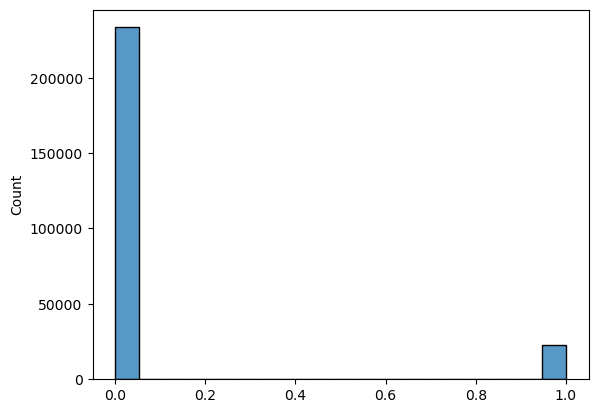

In [4]:
targets = np.round(targets)
sns.histplot(targets)

In [5]:
targets[targets == 1].shape

(22547,)

In [6]:
targets[targets == 0].shape

(233453,)

In [7]:
zero_indices = np.where(targets == 0)[0]
zero_indices = np.random.choice(zero_indices, 22547, replace=False)
zero_indices.shape

(22547,)

In [8]:
one_indices = np.where(targets == 1)[0]
indices = np.concatenate((one_indices, zero_indices))
indices.shape

(45094,)

In [9]:
new_targets = targets[indices]

<AxesSubplot: ylabel='Count'>

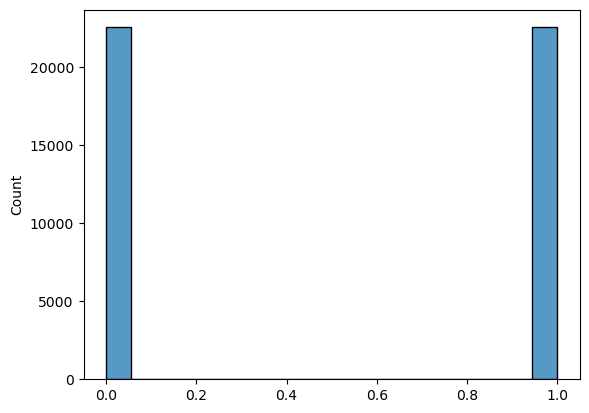

In [12]:
sns.histplot(new_targets)